In [1]:
import os 
from pathlib import Path
from dotenv import load_dotenv, find_dotenv

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
    
import os 
import tensorflow as tf
from pathlib import Path

# Specify which GPU(s) to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Or 2, 3, etc. other than 0

#config = tf.compat.v1.ConfigProto(device_count={'GPU': 1}, allow_soft_placement=True, log_device_placement=True)
config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 1.2
tf.compat.v1.Session(config=config)
tf.__version__

from tensorflow.keras.applications.densenet import DenseNet121

from src.metrics.metrics import F2Score
from src.metrics.losses import WeightedBinaryCrossentropy, compute_class_weight
from src.utils.gradcam import build_guided_model, compute_saliency
from src.architectures.simple.simple_base import SimpleBaseArchitecture
from src.utils.save_model import get_experiment, load_model
from src.architectures.benchmarks.benchmark_definitions import benchmark_from_logs, simple_architecture_experiment, CHEXPERT_COLUMNS

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Using TensorFlow backend.


In [2]:
MODEL_ID = '1a955742-e3ff-11ea-bd3d-0242ac110005'
ARCHITECTURE = DenseNet121
NUM_CLASSES = 12

In [8]:
exp_dict = get_experiment(identifier=MODEL_ID)
benchmark = benchmark_from_logs(exp_dict['benchmark'])

Initialzed custom_binary_crossentropy with epsilon 1e-05


In [9]:
def build_model():
    model = SimpleBaseArchitecture(ARCHITECTURE, NUM_CLASSES, train_last_layer_only=False)
    path = str(load_model(identifier=MODEL_ID))
    model.load_weights(path)

    return model

In [10]:
model = build_model()
guided_model = build_guided_model(build_model)

Model prediction:
	Enlarged Cardiomediastinum	(0)	with probability 	0.11156178265810013
	Atelectasis    	(7)	with probability 	0.11063012480735779
	Lung Opacity   	(2)	with probability 	0.07173296809196472
	Pneumothorax   	(8)	with probability 	0.06963814795017242
	Cardiomegaly   	(1)	with probability 	0.04209602251648903
	Consolidation  	(5)	with probability 	0.020130956545472145
	Edema          	(4)	with probability 	0.017883887514472008
	Pleural Effusion	(9)	with probability 	0.01719537004828453
	Pneumonia      	(6)	with probability 	0.009560306556522846
	Lung Lesion    	(3)	with probability 	0.002157510258257389
	Fracture       	(11)	with probability 	0.0011332288850098848
	Pleural Other  	(10)	with probability 	5.293703361530788e-05
Explanation for 'Enlarged Cardiomediastinum'


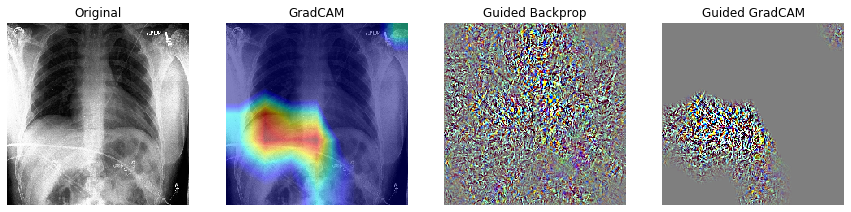

In [12]:
image = 'data/chexpert/full/CheXpert-v1.0-small/valid/patient64576/study1/view1_frontal.jpg'
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, image, layer_name='conv5_block16_2_conv', visualize=True, save=False, classes=benchmark.label_columns)